# Deep Q-Learning using CNN

This notebook demonstrates how to use Deep Q-Learning with a Convolutional Neural Network (CNN) to train an agent to solve the `MiniGrid-SimpleCrossingS11N5-v0` environment. We will utilize a Fully Observable Wrapper to provide complete state information to the agent.

## Import Libraries

We start by importing the necessary libraries. The `gymnasium` library is used for creating and interacting with the environment, `torch` is used for building and training the neural network, and `random` is used for action selection and experience replay sampling.

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from minigrid.wrappers import FullyObsWrapper

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.5.2 (SDL 2.30.2, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Create the Environment

We create the `MiniGrid-SimpleCrossingS11N5-v0` environment using the `gymnasium` library and wrap it with the `FullyObsWrapper` to provide fully observable states.

In [2]:
# Create the MiniGrid environment
env = gym.make(
    'MiniGrid-SimpleCrossingS11N5-v0', 
    # render_mode = 'human'
    )
# Provides fully observable states
env = FullyObsWrapper(env)

c:\Users\ahmad\anaconda3\envs\ailab-minigrid\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
c:\Users\ahmad\anaconda3\envs\ailab-minigrid\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


## Define the Device

We define the device for computation, utilizing GPU if available, otherwise falling back to CPU.

In [3]:
# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define the DQN Model

We define the `DQN` class, which sets up the Convolutional Neural Network (CNN) layers and the fully connected layers. The `forward` method defines the forward pass through the network.

In [4]:
# Setups CNN layers
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 256, kernel_size=3, stride=1, padding = 1), # First Neural network layer
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding = 1), # Second Neural network layer
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = 1), # Third Neural network layer
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding = 1), # Fourth Neural network layer
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding = 1), # Fifth Neural network layer
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

## Initialize the DQN Model

We initialize the policy and target networks, setting the input shape and number of actions based on the environment's observation and action spaces.

In [5]:
# Initialize the DQN model
input_shape = env.observation_space['image'].shape
num_actions = env.action_space.n
policy_net = DQN(input_shape, num_actions).to(device)
target_net = DQN(input_shape, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv): Sequential(
    (0): Conv2d(11, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1056, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=7, bias=True)
  )
)

## Hyperparameters

We define the hyperparameters for training, including batch size, discount factor, epsilon for exploration, target update frequency, replay memory size, number of episodes, and learning rate.

In [6]:
# Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.999
EPSILON_START = 1.0
EPSILON_END = 0.5
EPSILON_DECAY = 0.950
TARGET_UPDATE = 10
MEMORY_SIZE = 10000
NUM_EPISODES = 50
LR = 0.0001

## Replay Memory

We initialize the replay memory using a deque with a maximum length defined by `MEMORY_SIZE`.

In [7]:
# Replay memory
memory = deque(maxlen=MEMORY_SIZE)

## Optimizer

We initialize the Adam optimizer with the learning rate defined by `LR`.

In [8]:
# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

## Action Selection

We define a function `select_action` to select an action using an epsilon-greedy policy. The agent will explore with probability `epsilon` and exploit the best-known action otherwise.

In [9]:
# Function to select an action using an epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
            return policy_net(state).max(1)[1].item()

## Optimize Model

We define a function `optimize_model` to perform a single optimization step. This involves sampling a batch of transitions from the replay memory, computing the expected state-action values, and minimizing the loss using Mean Squared Error (MSE).

In [10]:
# Function to optimize the model
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = random.sample(memory, BATCH_SIZE)
    batch = list(zip(*transitions))

    states = torch.tensor(np.array(batch[0]), device=device, dtype=torch.float32) / 255.0
    actions = torch.tensor(batch[1], device=device).unsqueeze(1)
    rewards = torch.tensor(batch[2], device=device, dtype=torch.float32)
    next_states = torch.tensor(np.array(batch[3]), device=device, dtype=torch.float32) / 255.0
    dones = torch.tensor(batch[4], device=device, dtype=torch.float32)

    state_action_values = policy_net(states).gather(1, actions)
    next_state_values = target_net(next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA * (1 - dones)) + rewards

    loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Training Loop

We define the training loop, which runs for a specified number of episodes. In each episode, the agent interacts with the environment, collects experiences, and optimizes the model. We also update the target network periodically.

In [11]:
# Training loop
steps_done = 0
rewards_dqn = []
for episode in range(NUM_EPISODES):
    obs, _ = env.reset(seed = 46)
    state = obs['image'] # Convert HWC to CHW
    total_reward = 0
    terminated = False
    while not terminated:
        epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * \
                  np.exp(-1. * steps_done / EPSILON_DECAY)
        action = select_action(state, epsilon)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = next_obs['image']
        total_reward += reward
        memory.append((state, action, reward, next_state, terminated))
        state = next_state
        steps_done += 1
        
        optimize_model()
    # print(f"Episode {episode}: Reward: {reward}")
    # print(f"Episode {episode}: Total Reward: {total_reward}")
    rewards_dqn.append(total_reward)
    
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

env.close()
print("Training completed with DQN.")
print(f"Reward: {rewards_dqn}")

KeyboardInterrupt: 

## Plot Cumulative Rewards

Finally, we plot the cumulative rewards over episodes to visualize the agent's performance.

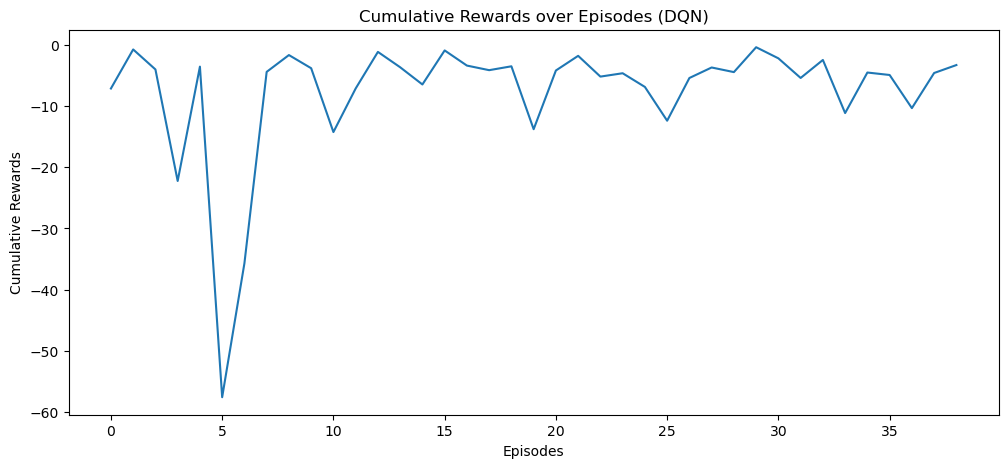

In [12]:
# Plot cumulative rewards
plt.figure(figsize=(12, 5))
plt.plot(rewards_dqn)
plt.title('Cumulative Rewards over Episodes (DQN)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.show()